In [68]:
push!(LOAD_PATH, "functions/")
using BP
using Arpack
using LinearAlgebra
using Random, Plots, SparseArrays, ITensors, Statistics, ProgressMeter, Colors
include("ldpc_tanner_loops.jl")
include("toric_loops.jl")
using .ToricLoops


function parity_tensor(index_arr, parity)
    num = length(index_arr)
    tens = ITensor(index_arr)
    for i in 0:(2^num - 1)
        bits = digits(i, base=2, pad=num) 
        if sum(bits) % 2 == parity
            inds_tuple = (index_arr[j] => bits[j] + 1 for j in 1:num)
            tens[inds_tuple...] = 1.0        
        end 
    end
    return tens 
end 

function get_nbrs_of_check(adj_mat, v)
    ## get nbrs of node v from adj_mat
    row = adj_mat[v, :]
    return findall(x -> x == 1, row)
end

function get_nbrs_of_data(adj_mat, v)
    ## get nbrs of node v from adj_mat
    col = adj_mat[:, v]
    return findall(x -> x == 1, col)
end

function get_network(pcmat, syndrome, pbias)
    ## pcmat: (n-k) x (n)
    ## syndrome: (n-k)
    ## close syndrome legs with given syndrome, keeps data legs open for later
    m, n = size(pcmat)
    k = n - m 
    indmat = [Index(2, "s$(i)d$(j)") for i in 1:m, j in 1:n]
    datainds = [Index(2, "x$i") for i in 1:n]
    data_tensors = []
    syn_tensors = []

    ## data data_tensors

    for i = 1:n 
        dummy = Index(2, "biasi")
        biastensor = ITensor( [1-pbias, pbias],dummy)
        checks = get_nbrs_of_data(pcmat,i)
        indxs = [indmat[jj,i] for jj in checks]
        push!(indxs,dummy)
        push!(indxs,datainds[i])
        push!(data_tensors,(delta(indxs) * biastensor))
    end 

    ## check tensors 
    for j = 1:m
        datas = get_nbrs_of_check(pcmat,j)
        tensor = parity_tensor([indmat[j,ii] for ii in datas],syndrome[j])
        push!(syn_tensors,tensor)
    end 
    return data_tensors, syn_tensors, datainds
end 


function bit_to_onehot(x)
    if x == 0
        return [1, 0]
    elseif x == 1
        return [0, 1]
    elseif x == -1
        return [1, 1] ./ 2
    else
        error("Input must be -1, 0, or 1")
    end
end


function get_marginal_data_tensors(data_tensors,data_indices,data_inputs;exclude=[])
    N = length(data_tensors)
    marginalized = []
    for i = 1 : N 
        if !(i in exclude)
            tens = data_tensors[i] *  ITensor(bit_to_onehot(data_inputs[i]),data_indices[i])
        else 
            tens = data_tensors[i]
        end 
        push!(marginalized,tens)
    end 
    return marginalized
end 


function sample_bit(p0)
    return rand() < p0 ? 0 : 1
end

function toric_code_X_parity_matrix(L::Int)
    N = 2 * L^2   # number of qubits
    M = L^2       # number of X checks (vertices)
    
    pcmat = spzeros(Int, M, N)
    
    for v in 1:M
        i = div(v-1, L) + 1  # vertex row
        j = mod1(v, L)       # vertex col
        
        # Horizontal edges (apply periodic boundary for i-1)
        h_edge1 = (mod1(i-1, L) - 1)*L + j
        h_edge2 = (mod1(i, L) - 1)*L + j
        
        # Vertical edges
        v_edge1 = L^2 + (i-1)*L + mod1(j-1, L)
        v_edge2 = L^2 + (i-1)*L + j
        
        pcmat[v, h_edge1] = 1
        pcmat[v, h_edge2] = 1
        pcmat[v, v_edge1] = 1
        pcmat[v, v_edge2] = 1
    end
    
    return pcmat
end

function toric_code_logical_operators(L::Int)
    # Compute the null space (logical operators) of the toric code parity check matrix
    pcmat = toric_code_X_parity_matrix(L)
    N = 2 * L^2
    
    # Convert to GF(2) by using mod 2 arithmetic
    # We'll manually construct the logical operators for the toric code
    
    # For a toric code of size L, there are 2 logical X and 2 logical Z operators
    # We'll return the logical Z operators (null space of X check matrix)
    
    # Create logical operators matrix (2 logical operators)
    logical_ops = zeros(Int, 2, N)
    
    # First logical operator: horizontal loop around the torus
    for i = 1:L
        logical_ops[1, (i-1)*L + 1] = 1  # First column of each row
    end
    
    # Second logical operator: vertical loop around the torus
    for j = 1:L
        logical_ops[2, L^2 + j] = 1  # First row of vertical edges
    end
    
    # Verify these are in the null space (PCM * logical_ops' = 0 mod 2)
    @assert all([(pcmat * logical_ops'[:,i]) .% 2 == zeros(L^2) for i in 1:2])
    
    return logical_ops
end


function get_marginal(tensors,adj_mat,messages,index)
    nbrs = BP.get_nbrs(adj_mat, index)
    Z_local = tensors[index] 
    for nbr in nbrs
        Z_local *= messages[nbr,index] 
    end
    return Z_local
end 

function loop_contribution(loop, messages, tensors, edges, links, adj_mat)
    # Initialize tracking variables
    vertices_done = Set()  # Track which vertices have been processed
    loop_contri = 1        # Accumulate the loop contribution tensor product
    N = length(tensors)    # Total number of vertices in tensor network
    
    # Step 1: Process each edge in the loop
    for edge in loop
        v1, v2 = edge  # v1 < v2 by convention 
        
        # Replace BP message with excited projector P⊥ = I - μ†μ
        excitation = BP.excited_edge(edge, messages, edges, links, adj_mat)
        loop_contri *= excitation
        
        # Step 2a: Process vertex v1 (if not already done)
        if !(v1 in vertices_done)
            vertices_done = union(vertices_done, v1)
            
            # Find all vertices connected to v1 within the loop
            excited_neighbors = Set([other_vertex for edge in loop if v1 in edge for other_vertex in edge if other_vertex != v1])
            
            # Determine which indices need priming for proper tensor contraction
            edges_with_v1 = filter(t -> v1 in t, loop)  # Find loop edges containing v1
            edge_indices = [findfirst(isequal(t), edges) for t in edges_with_v1]  # Map to global edge list
            larger_bools = [v1 == max(t[1], t[2]) for t in edges_with_v1]  # v1 is larger vertex → prime needed
            selected_links = links[edge_indices[larger_bools]]  # Select indices to prime
            
            # Apply tensor T_v1 with appropriate index priming
            contri = !isempty(selected_links) ? prime(tensors[v1], selected_links...) : tensors[v1]
            loop_contri *= contri
            
            # Add BP messages from neighbors outside the loop
            for w in BP.get_nbrs(adj_mat, v1)
                current_edge = (min(v1,w), max(v1,w))  # Standard edge ordering
                edge_index = findfirst(e -> e == current_edge, edges)
                current_link = links[edge_index]
                
                # Only add message if: (1) index exists in current contraction, (2) neighbor is outside loop
                if current_link in inds(loop_contri) && !(w in excited_neighbors)
                    loop_contri *= messages[w,v1]  
                end
            end
        end
        
        # Step 2b: Process vertex v2 (if not already done) - identical logic to v1
        if !(v2 in vertices_done)
            vertices_done = union(vertices_done, v2)
            excited_neighbors = Set([other_vertex for edge in loop if v2 in edge for other_vertex in edge if other_vertex != v2])
            edges_with_v2 = filter(t -> v2 in t, loop) 
            edge_indices = [findfirst(isequal(t), edges) for t in edges_with_v2]
            larger_bools = [v2 == max(t[1], t[2]) for t in edges_with_v2]
            selected_links = links[edge_indices[larger_bools]]
            contri = !isempty(selected_links) ? prime(tensors[v2], selected_links...) : tensors[v2]
            loop_contri *= contri 

            for w in BP.get_nbrs(adj_mat, v2)
                current_edge = (min(v2,w), max(v2,w))  
                edge_index = findfirst(e -> e == current_edge, edges)
                current_link = links[edge_index]

                if current_link in inds(loop_contri) && !(w in excited_neighbors)
                    loop_contri *= messages[w,v2]  
                end
            end
        end
    end
    
    # Step 3: Contract to scalar and multiply by BP partition function on remaining vertices
    # Loop contribution (scalar) × BP partition function on vertices outside the loop
    return (loop_contri) #* mean_free_partition_fn(setdiff(Set(1:N), vertices_done), tensors, messages, edges, links, adj_mat)
end

function tensorargmax(probs)
    ix = inds(probs)[1]
    probs = [real((probs)[ix=>n]) for n in 1:dim(ix)]
    probs ./= sum(probs)
    return Int(argmax(probs)-1) #sample_bit(probs[1])
end 

tensorargmax (generic function with 1 method)

In [ ]:
L = 7
p = 0.02
pbias = p

pcmat = toric_code_X_parity_matrix(L)
m, n = size(pcmat)
# Track errors within this batch
logical_errors = []
logical_ops = toric_code_logical_operators(L);

In [180]:
## method2
# Sample errors iid with probability p
errors_true = [sample_bit(1-p) for _ in 1:n]
# Compute syndrome
syndrome = pcmat * errors_true .% 2;

# tannerloopslist = [find_tanner_loops(pcmat, d; max_length=max_loop_order) for d in 1:n]
err_bits = collect(findall(==(1), errors_true))  # only correct on these bits



max_loop_order = 10
data_tensors, syn_tensors, data_indices = get_network(pcmat, syndrome, pbias)
errors = Int.(-1 .* ones(n))
tensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors), syn_tensors)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages = BP.message_passing(tensors,messages,edges,links,adj_mat;α=0.95, max_iters=500,diagnose=false,normalise=true)



for d = 1:n 
    probs = (get_marginal(vcat(data_tensors,syn_tensors),adj_mat,messages,d))
    vacuum = tensorargmax(probs)

    # if d in err_bits
    #     probs *= 0 
    # end 
    tannerloops = ToricLoops.find_toric_code_loops(pcmat, d, max_loop_order)
    loop_list = [tannerloop.edges for tannerloop in tannerloops] 
    data_bits_involved_list = [tannerloop.data_qubits for tannerloop in tannerloops]
    check_bits_involved_list = [[c - n for c in tannerloop.check_qubits] for tannerloop in tannerloops]
    loopprobs = ITensor([0,0], data_indices[d])
    for (i, loop) in enumerate(loop_list)
        data_bits_involved = data_bits_involved_list[i] 
        check_bits_involved = check_bits_involved_list[i] 
        mtensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors; exclude=[d]), syn_tensors)
        normlz1 = scalar(prod([get_marginal(mtensors,adj_mat,messages,other_data_bit) for other_data_bit in collect(setdiff(data_bits_involved, [d]))]))
        normlz2 = scalar(prod([get_marginal(mtensors,adj_mat,messages,n+check_bit) for check_bit in check_bits_involved]))
        normlz = normlz1  * normlz2
        change = loop_contribution(loop, messages, mtensors, edges, links, adj_mat) / normlz
        loopprobs += change 
    end
    # if d in err_bits 
    #     println(probs)
    #     println(loopprobs)
    # end 
    loopcorr = tensorargmax(probs + loopprobs)
    error_i = loopcorr
    # if vacuum != loopcorr 
    #     println("loopcorr at ", d)
    #     println(probs)
    #     println(loopprobs)
    # end

    errors[d] = error_i
end


residual = (errors .+ errors_true) .% 2
synerror =  all(x -> x == 0, (pcmat * residual) .% 2)
logerror = all(x -> x == 0, (logical_ops * residual) .% 2)
println("syndrome compatible? ", synerror)
println("logical compatible? ", logerror)

syndrome compatible? true
logical compatible? true


In [193]:
# =============================================================================
# COMPLETE LOGICAL ERROR PROBABILITY ANALYSIS FUNCTIONS
# =============================================================================

function compute_logical_error_probability(L::Int, p::Float64, nsamples::Int; max_loop_order::Int=8)
    """
    Compute logical error probability for toric code using tensor network belief propagation.
    Returns: (mean, std) - logical error probability mean and standard deviation
    """
    pbias = p  # Set bias probability equal to physical error probability
    
    # Initialize toric code
    pcmat = toric_code_X_parity_matrix(L)
    logical_ops = toric_code_logical_operators(L)
    m, n = size(pcmat)
    
    logical_errors = 0
    
    println("Computing logical error probability for L=$L, p=$p over $nsamples samples...")
    
    @showprogress for sample in 1:nsamples
        # Sample errors iid with probability p
        errors_true = [sample_bit(1-p) for _ in 1:n]
        
        # Compute syndrome
        syndrome = pcmat * errors_true .% 2
        
        # Set up tensor network
        data_tensors, syn_tensors, data_indices = get_network(pcmat, syndrome, pbias)
        errors = Int.(-1 .* ones(n))
        tensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors), syn_tensors)
        adj_mat, edges, links = BP.get_adj_mat(tensors)
        messages = BP.get_messages(tensors, edges, links) 
        messages = BP.message_passing(tensors, messages, edges, links, adj_mat; 
                                    α=0.95, max_iters=500, diagnose=false, normalise=true)
        
        # Decode each data qubit
        for d = 1:n 
            probs = get_marginal(vcat(data_tensors, syn_tensors), adj_mat, messages, d)
            vacuum = tensorargmax(probs)
            
            # Get loops for this data qubit
            tannerloops = ToricLoops.find_toric_code_loops(pcmat, d, max_loop_order)
            loop_list = [tannerloop.edges for tannerloop in tannerloops] 
            data_bits_involved_list = [tannerloop.data_qubits for tannerloop in tannerloops]
            check_bits_involved_list = [[c - n for c in tannerloop.check_qubits] for tannerloop in tannerloops]
            
            loopprobs = ITensor([0,0], data_indices[d])
            for (i, loop) in enumerate(loop_list)
                data_bits_involved = data_bits_involved_list[i] 
                check_bits_involved = check_bits_involved_list[i] 
                mtensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors; exclude=[d]), syn_tensors)
                
                if !isempty(setdiff(data_bits_involved, [d]))
                    normlz1 = scalar(prod([get_marginal(mtensors, adj_mat, messages, other_data_bit) 
                                         for other_data_bit in collect(setdiff(data_bits_involved, [d]))]))
                else
                    normlz1 = 1.0
                end
                
                if !isempty(check_bits_involved)
                    normlz2 = scalar(prod([get_marginal(mtensors, adj_mat, messages, n+check_bit) 
                                         for check_bit in check_bits_involved]))
                else
                    normlz2 = 1.0
                end
                
                normlz = normlz1 * normlz2
                if normlz != 0
                    change = loop_contribution(loop, messages, mtensors, edges, links, adj_mat) / normlz
                    loopprobs += change 
                end
            end
            
            loopcorr = tensorargmax(probs + loopprobs)
            errors[d] = loopcorr
        end
        
        # Check for logical error
        residual = (errors .+ errors_true) .% 2
        synerror = all(x -> x == 0, (pcmat * residual) .% 2)
        
        if !synerror
            # Syndrome error occurred - this is a logical error
            logical_errors += 1
        else
            # Check logical operators
            logerror = all(x -> x == 0, (logical_ops * residual) .% 2)
            if !logerror
                # Logical error occurred
                logical_errors += 1
            end
        end
    end
    
    # Calculate mean and standard deviation
    logical_error_rate = logical_errors / nsamples
    
    # For binomial distribution: variance = n*p*(1-p), std = sqrt(variance)/n
    variance = logical_error_rate * (1 - logical_error_rate) / nsamples
    std_error = sqrt(variance)
    
    println("Logical error rate: $logical_error_rate ± $std_error ($logical_errors/$nsamples)")
    
    return logical_error_rate, std_error
end

function sweep_logical_error_probability(L::Int, p_values::Vector{Float64}, nsamples::Int; max_loop_order::Int=8)
    """
    Sweep logical error probability over multiple physical error rates.
    Returns: (means, stds) - vectors of logical error probability means and standard deviations
    """
    means = Float64[]
    stds = Float64[]
    
    println("=== SWEEPING LOGICAL ERROR PROBABILITY ===")
    println("L = $L, nsamples = $nsamples, max_loop_order = $max_loop_order")
    println("Testing p values: $p_values")
    println()
    
    for p in p_values
        println("Testing p = $p...")
        logical_error_rate, std_error = compute_logical_error_probability(L, p, nsamples; max_loop_order=max_loop_order)
        push!(means, logical_error_rate)
        push!(stds, std_error)
        println("p = $p: Logical error rate = $logical_error_rate ± $std_error\n")
    end
    
    return means, stds
end

function plot_logical_error_curves(L_values::Vector{Int}, p_values::Vector{Float64}, nsamples::Int; 
                                  max_loop_order::Int=8, save_data::Bool=true)
    """
    Plot logical error probability curves for multiple system sizes with error bars.
    """
    
    # Color gradient: cooler to warmer colors for increasing L
    colors = palette(:thermal, length(L_values))
    
    # Initialize plot
    fig = plot(size=(900, 650), 
              title="Logical Error Probability vs Physical Error Probability\n" *
                    "Toric Code Tensor Network BP Decoder ($(nsamples) samples/point)",
              xlabel="Physical Error Probability (p)",
              ylabel="Logical Error Probability",
              legend=:topleft,
              grid=true,
              gridwidth=1,
              gridcolor=:lightgray,
              background_color=:white,
              dpi=300)
    
    # Store results
    all_data = Dict()
    
    println("=== PLOTTING LOGICAL ERROR CURVES ===")
    println("L values: $L_values")
    println("p values: $p_values") 
    println("Samples per point: $nsamples")
    println("Max loop order: $max_loop_order\n")
    
    # Plot each system size
    for (i, L) in enumerate(L_values)
        println("Processing L = $L...")
        
        # Use the sweep function - now returns means and stds
        logical_error_rates, std_errors = sweep_logical_error_probability(L, p_values, nsamples; 
                                                                        max_loop_order=max_loop_order)
        
        # Store data
        all_data[L] = (means=logical_error_rates, stds=std_errors)
        
        # Add to plot with error bars and color gradient
        plot!(fig, p_values, logical_error_rates,
              yerror=std_errors,
              marker=:circle,
              markersize=7,
              linewidth=3,
              color=colors[i],
              label="L = $L",
              markerstrokewidth=1,
              markerstrokecolor=colors[i],
              alpha=0.8)
        
        println("Completed L = $L: $(round.(logical_error_rates, digits=4)) ± $(round.(std_errors, digits=4))\n")
    end
    
    # Add reference line
    plot!(fig, p_values, p_values, 
          linestyle=:dash, 
          color=:gray, 
          alpha=0.6, 
          label="Uncoded (p)",
          linewidth=2)
    
    # Format plot
    max_val = maximum([maximum(all_data[L].means .+ all_data[L].stds) for L in L_values])
    ylims!(fig, (0, max_val * 1.05))
    xlims!(fig, (minimum(p_values) * 0.95, maximum(p_values) * 1.05))
    
    # Print summary table
    println("=== RESULTS TABLE ===")
    header = "p\\L\t" * join(["L=$L (mean±std)" for L in L_values], "\t\t")
    println(header)
    println("-" * repeat("-", length(header)))
    
    for (i, p) in enumerate(p_values)
        row = "$p\t"
        for L in L_values
            mean_val = round(all_data[L].means[i], digits=4)
            std_val = round(all_data[L].stds[i], digits=4)
            row *= "$(mean_val)±$(std_val)\t\t"
        end
        println(row)
    end
    
    display(fig)
    
    if save_data
        return fig, all_data
    else
        return fig
    end
end

println("=== FUNCTIONS LOADED ===")
println("Available functions:")
println("1. compute_logical_error_probability(L, p, nsamples; max_loop_order=8) -> (mean, std)")
println("2. sweep_logical_error_probability(L, p_values, nsamples; max_loop_order=8) -> (means, stds)")
println("3. plot_logical_error_curves(L_values, p_values, nsamples; max_loop_order=8) -> (fig, data)")
println("\nExample usage:")
println("# Single calculation:")
println("mean, std = compute_logical_error_probability(3, 0.05, 100)")
println("\n# Sweep over p values:")
println("means, stds = sweep_logical_error_probability(3, [0.01, 0.03, 0.05], 50)")
println("\n# Full analysis with plots (includes error bars):")
println("fig, data = plot_logical_error_curves([3, 5, 7], [0.01, 0.03, 0.05, 0.07, 0.09], 50)")

In [215]:
compute_logical_error_probability(3, 0.02, 5000; max_loop_order=0)

(0.024, 0.002164439881354989)

In [216]:
compute_logical_error_probability(3, 0.02, 5000; max_loop_order=8)

(0.0188, 0.0019207581836347854)

In [217]:
compute_logical_error_probability(5, 0.02, 5000; max_loop_order=0)

(0.0484, 0.0030350433275325743)

In [222]:
compute_logical_error_probability(3, 0.005, 5000; max_loop_order=8)

(0.0014, 0.0005287797272967262)

In [223]:
compute_logical_error_probability(5, 0.005, 5000; max_loop_order=8)

(0.0044, 0.0009360170938610043)

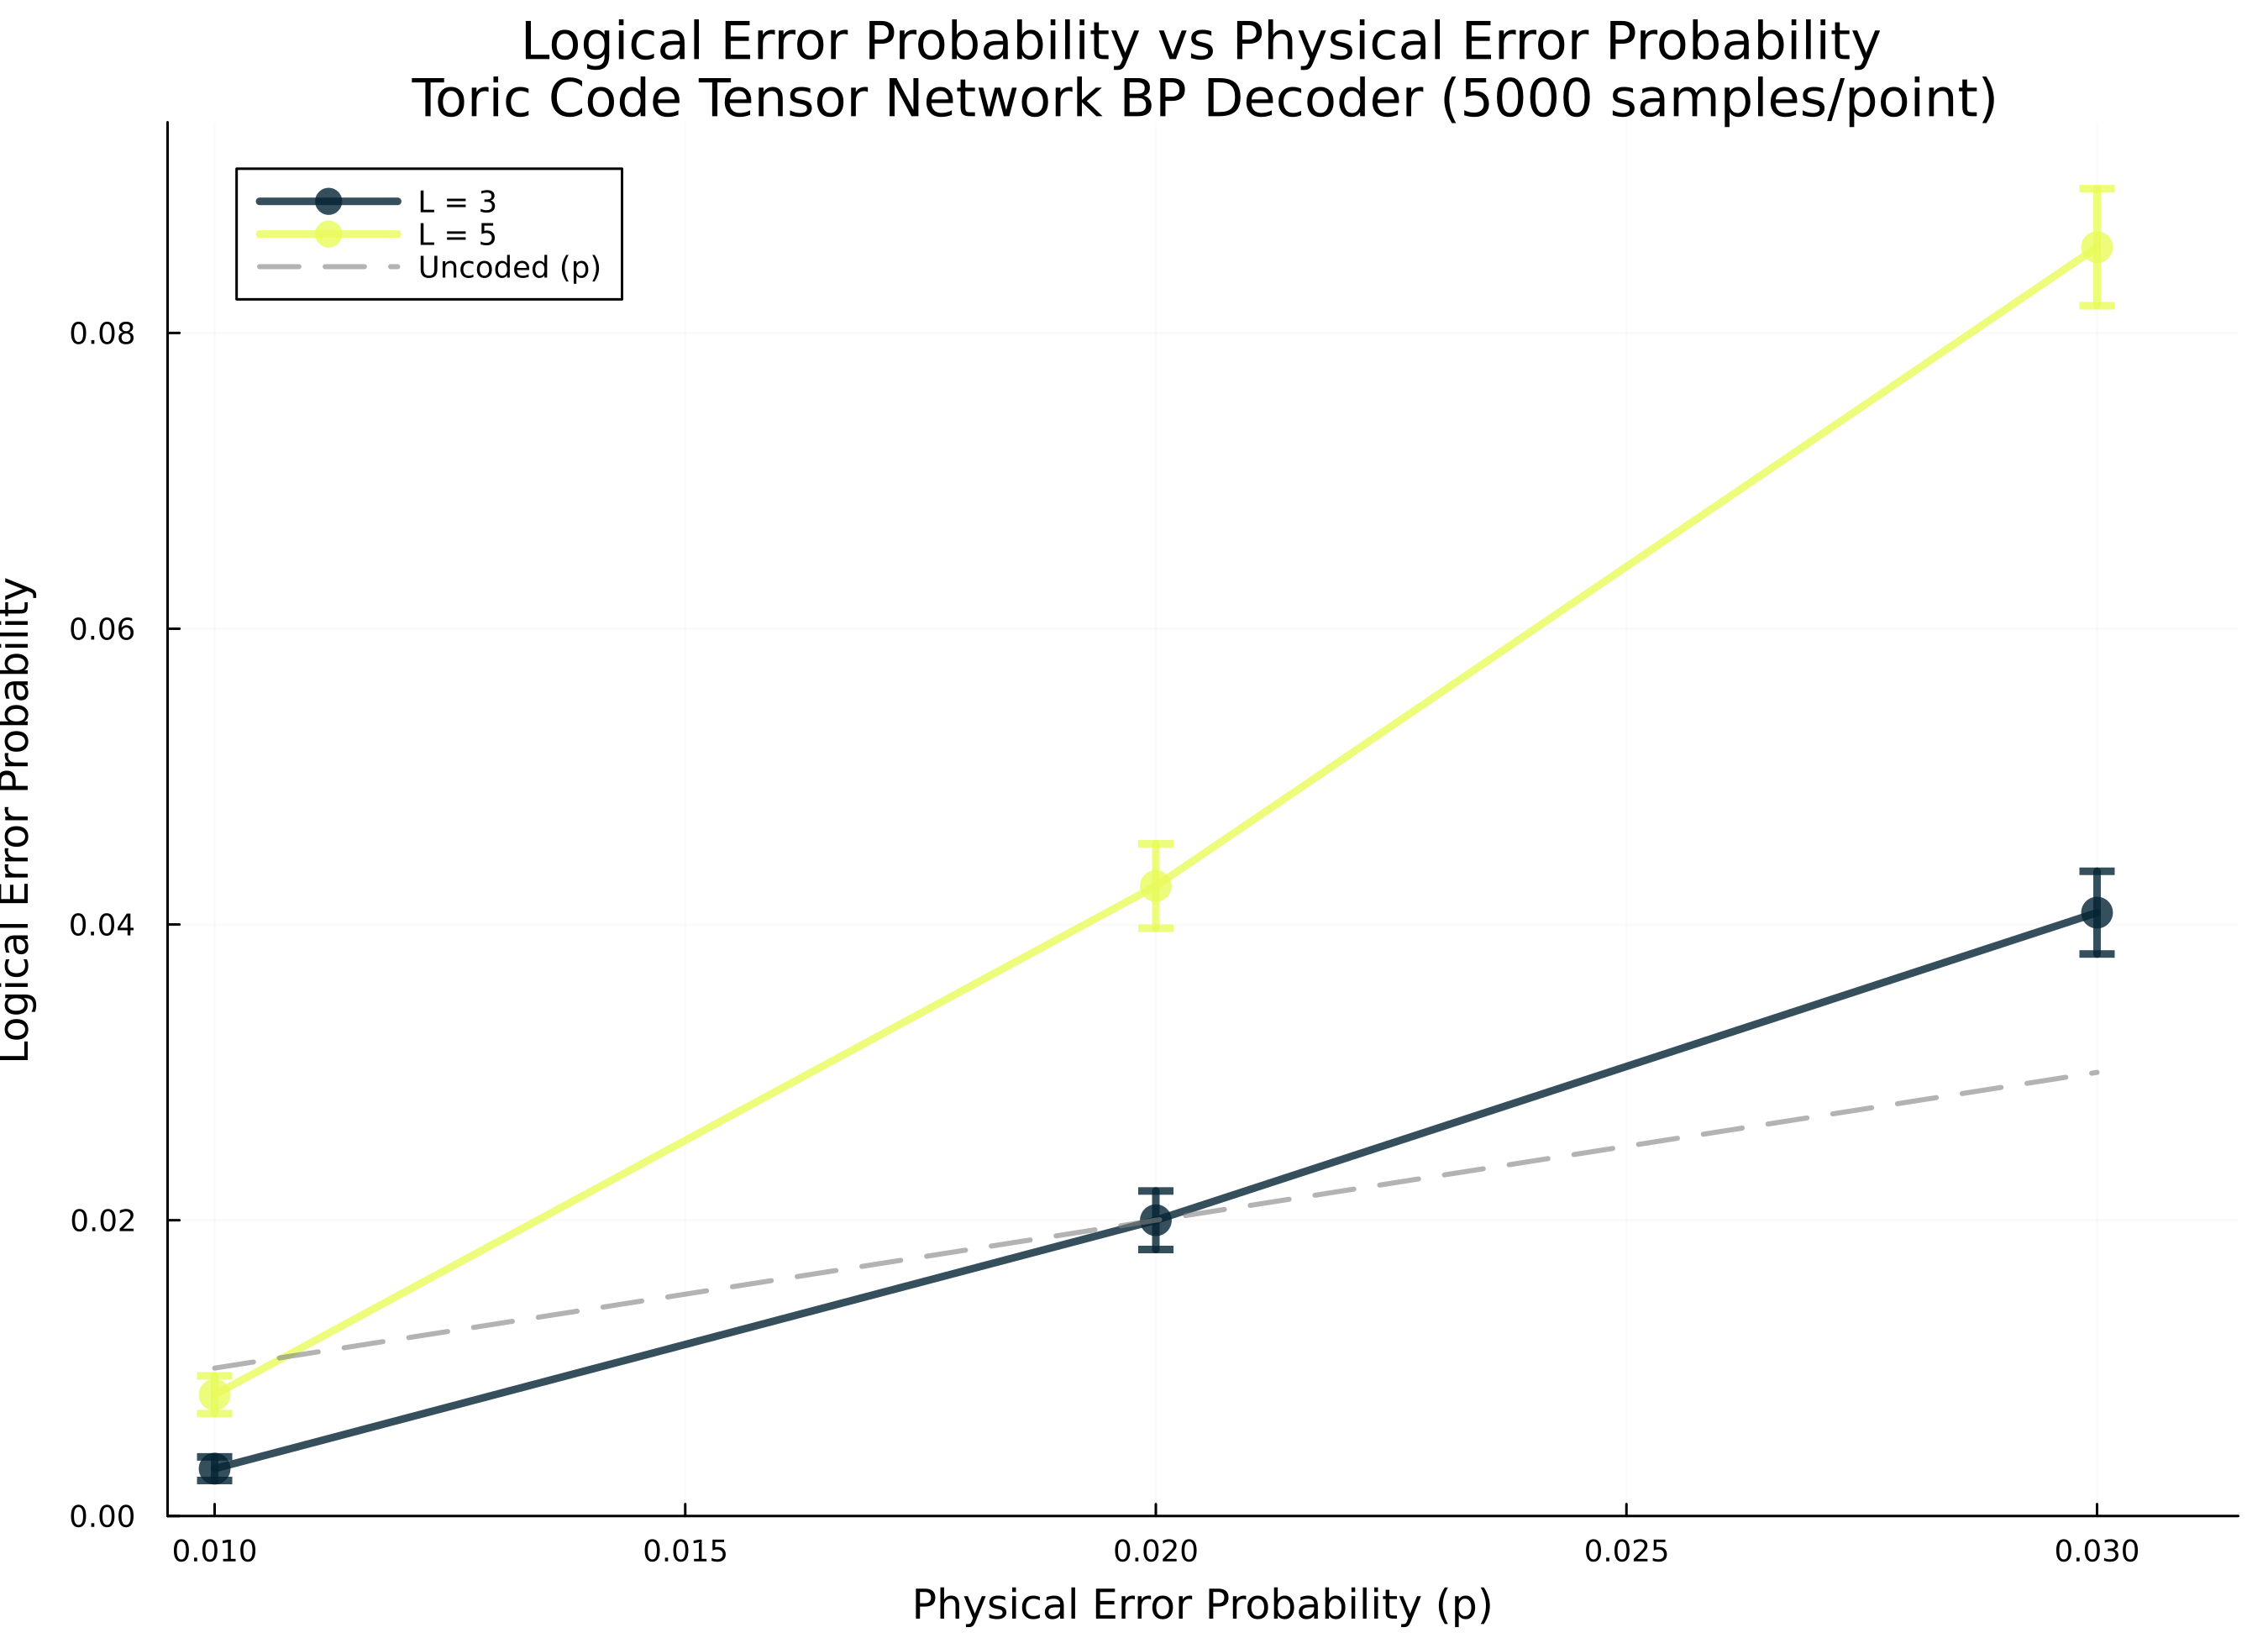

(Plot{Plots.GRBackend() n=3}, Dict{Any, Any}(5 => (means = [0.0082, 0.0426, 0.0858], stds = [0.0012753634776015816, 0.00285605462132642, 0.003960766592466665]), 3 => (means = [0.0032, 0.02, 0.0408], stds = [0.0007987189743583158, 0.001979898987322333, 0.002797690476089162])))

In [ ]:
plot_logical_error_curves([3,5],[0.005, 0.01,0.02,0.03],5000; max_loop_order = 8)